In [12]:
import tensorflow as tf

import os
import sys
import numpy as np
from scipy.io import savemat
from sklearn.linear_model import SGDClassifier

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sys.path.append(os.path.abspath('helper'))
# import utils
# import loader
import utils_UDA_FiLM, PAD
from utils_UDA_FiLM import UDA_FiLM_Output, train_step_Output

In [1]:
import tensorflow as tf
print(tf.__version__)

2025-07-30 09:49:55.257732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753883395.392878  397566 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753883395.433870  397566 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753883395.702119  397566 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753883395.702157  397566 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753883395.702162  397566 computation_placer.cc:177] computation placer alr

2.19.0


In [13]:
notebook_dir = os.getcwd()
print(notebook_dir)
print(os.path.abspath(os.path.join(notebook_dir, '..', '..')))
sys.path.append(os.path.abspath(os.path.join(notebook_dir, '..', '..')))
import Est_btween_CSIRS.helper.utils as utils_CNN
import Est_btween_CSIRS.helper.loader as loader
import Est_btween_CSIRS.helper.plotfig as plotfig

/home/thien/Code/H_predict_UDA/H_predict_Sionna/Domain_Adaptation/Domain_Adversarial
/home/thien/Code/H_predict_UDA/H_predict_Sionna


In [14]:
source_data_file_path = os.path.abspath(os.path.join(notebook_dir, '..', '..', 'Generate_Data', 'CDL_Channel', 'generatedChannel', 'ver3_', '0dB', 'mapBaseData.mat'))
target_data_file_path = os.path.abspath(os.path.join(notebook_dir, '..', '..', 'Generate_Data', 'Sionna', 'generatedChannel', 'ver3_', 'sionnaTrue.mat'))

In [15]:
learning_rate = 0.0001
norm_approach = 'minmax' # can be set to 'std'
lower_range = -1 
    # if norm_approach = 'minmax': 
        # =  0 for scaling to  [0 1]
        # = -1 for scaling to [-1 1]
    # if norm_approach = 'std': can be any value, but need to be defined
    
# snr_start = -25
# snr_step = 5
# snr_end = 25
# SNR = np.arange(snr_start, snr_end+1, snr_step)

# SNR = np.array([0])

# if len(SNR) >1:
#     SNR_txt = f'{snr_start}:{snr_step}:{snr_end}'
# else:
#     SNR_txt = f'{SNR[0]}'
    
# ============ CNN settings ==============
if norm_approach == 'minmax':
    if lower_range == 0:
        norm_txt = 'Using min-max [0 1]'
    elif lower_range ==-1:
        norm_txt = 'Using min-max [-1 1]'
elif norm_approach == 'no':
    norm_txt = 'No'
    
CNN_activation = 'Tanh'
CNN_DropOut = 0.2
if CNN_DropOut != 0:
    dropOut_txt = f'Add p={CNN_DropOut} DropOut'
    
# ============ Adversarial for Domain Discriminator settings ==============
domain_disc = 'conv' # 'dense' or 'conv'
first_layer_disc = 'pool' # 'flatten' or 'pool' - only matters when domain_disc = 'dense'
                            # note: flatten may cause exhausted memory 
extract_layer = 3  # extract features after convelution layer 3 
# extract_layer = 5
lambda_domain=0.1
lambda_domain_cond = 0.1
text_lambda = f'lambda_domain = {lambda_domain}'
    
    
# create readme.txt file
content = f"""Generated by file 'Domain_Adversarial/UDA_CNN_v3.ipynb'.
28 GHz fc,
Source dataset got from {source_data_file_path},
Target dataset got from {target_data_file_path},
Learning rate {learning_rate},
{norm_txt} scaler for each sample
Using {CNN_activation} as activation function of CNN
{dropOut_txt}
========= For Domain Discriminator ==========
Extract features after layer {extract_layer} of CNN
{text_lambda}
"""

In [16]:
# Paths to save
idx_save_path = loader.find_incremental_filename(notebook_dir + '/model/CNN','ver', '_', '')

save_model = 0
model_path = notebook_dir + '/model/CNN/ver' + str(idx_save_path) + '_'
# figure_path = notebook_dir + '/model/CNN/ver' + str(idx_save_path) + '_/figure'
model_readme = model_path + '/readme.txt'
# figure_readme = figure_path + '/readme.txt'

# if not os.path.exists(os.path.dirname(model_readme)):
#     os.makedirs(os.path.dirname(model_readme))
# # if not os.path.exists(os.path.dirname(figure_readme)):
# #     os.makedirs(os.path.dirname(figure_readme))

# # Open the file in write mode ('w'). If the file does not exist, it will be created.
# with open(model_readme, 'w') as file:
#     # Write the content to the file
#     file.write(content)

# # with open(figure_readme, 'w') as file:
# #     # Write the content to the file
# #     file.write(content)

# print(f"File '{model_readme}'  created and content written.")


In [17]:
import h5py

batch_size=16

# ============ Source data ==============
source_file = h5py.File(source_data_file_path, 'r')
H_true_source = source_file['H_true']
N_samp_source = H_true_source.shape[0]
print('N_samp_source = ', N_samp_source)

# ============ Target data ==============
target_file = h5py.File(target_data_file_path, 'r')
H_true_target = target_file['H_true']
N_samp_target = H_true_target.shape[0]
print('N_samp_target = ', N_samp_target)

N_samp_source =  2048
N_samp_target =  2048


In [18]:
indices_source = np.arange(N_samp_source)
np.random.shuffle(indices_source)
indices_target = np.arange(N_samp_target)
np.random.shuffle(indices_target)
#
train_size = int(np.floor(N_samp_source * 0.9) // batch_size * batch_size)
val_size = N_samp_source - train_size

# Repeat the indices to match the maximum number of samples
N_samp = max(N_samp_source, N_samp_target) 
indices_source = np.resize(indices_source, N_samp)
indices_target = np.resize(indices_target, N_samp)

# =======================================================
## Divide the indices into training and validation sets
indices_train_source = indices_source[:train_size]
indices_val_source   = indices_source[train_size:train_size + val_size]

indices_train_target = indices_target[:train_size]
indices_val_target   = indices_target[train_size:train_size + val_size]

# to test code
# indices_train_source = indices_source[:96]
# indices_val_source = indices_source[2032:]
# indices_train_target = indices_target[:96]
# indices_val_target = indices_target[2032:]

print('train_size = ', indices_train_source.shape[0])
print('val_size = ', indices_val_source.shape[0])

train_size =  1840
val_size =  208


In [19]:
# =========== Source dataset ==============
loader_H_true_train_source = utils_CNN.H5BatchLoader(source_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_train_source)
loader_H_1_6_11_train_source = utils_CNN.H5BatchLoader(source_file, 'H_linear_1_6_11', batch_size=batch_size, shuffled_indices=indices_train_source)
    # channel at symbol 2 of slots 1,6,11 (channel corresponding to CSI-RS 1, 2, 3)
loader_H_true_val_source = utils_CNN.H5BatchLoader(source_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_val_source)
loader_H_1_6_11_val_source = utils_CNN.H5BatchLoader(source_file, 'H_linear_1_6_11', batch_size=batch_size, shuffled_indices=indices_val_source)

# =========== Target dataset ==============
loader_H_true_train_target = utils_CNN.H5BatchLoader(target_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_train_target)
    # actually at target domain, we don't have true channels, just use this for evaluating the model
loader_H_1_6_11_train_target = utils_CNN.H5BatchLoader(target_file, 'H_linear_1_6', batch_size=batch_size, shuffled_indices=indices_train_target)
    # channel at symbol 2 of slots 1,6,11 (channel corresponding to CSI-RS 1, 2)
loader_H_true_val_target = utils_CNN.H5BatchLoader(target_file, dataset_name='H_true', batch_size=batch_size, shuffled_indices=indices_val_target)
loader_H_1_6_11_val_target = utils_CNN.H5BatchLoader(target_file, 'H_linear_1_6', batch_size=batch_size, shuffled_indices=indices_val_target)

print('size loader_H_true_train = ', loader_H_true_train_target.total_batches)
print('size loader_H_true_val = ', loader_H_true_val_target.total_batches)

size loader_H_true_train =  115
size loader_H_true_val =  13


In [22]:
# Calculate PAD for original datasets with SVM
pad = PAD.original_PAD(loader_H_1_6_11_train_source, loader_H_1_6_11_train_target)
print(f"PAD = {pad:.4f}")

X shape =  (3680, 3168)
X1 shape =  (1840, 3168) y1 shape =  (1840,)
(1840, 3168) (1840,)
C: 0.01, Error rate: 0.0321
C: 0.1, Error rate: 0.0304
C: 0.5, Error rate: 0.0288
C: 1.0, Error rate: 0.0277
C: 2.0, Error rate: 0.0272
C: 5.0, Error rate: 0.0038
C: 10.0, Error rate: 0.0033
C: 50.0, Error rate: 0.0027
C: 100.0, Error rate: 0.0027
C: 500.0, Error rate: 0.0027
C: 1000.0, Error rate: 0.0027
Best C: 50.0, Best error rate: 0.0027
PAD = 1.9891
PAD = 1.9891


In [20]:
# Calculate PAD for original datasets with SGD
pad = PAD.original_PAD_SGD(loader_H_1_6_11_train_source, loader_H_1_6_11_train_target)
print(f"PAD = {pad:.4f}")

X shape =  (3680, 3168)
X1 shape =  (1840, 3168) y1 shape =  (1840,)
(1840, 3168) (1840,)
alpha: 1e-06, Error rate: 0.4978
alpha: 4.641588833612782e-06, Error rate: 0.4978
alpha: 2.1544346900318823e-05, Error rate: 0.4978
alpha: 0.0001, Error rate: 0.4978
alpha: 0.00046415888336127773, Error rate: 0.4978
alpha: 0.002154434690031882, Error rate: 0.5022
alpha: 0.01, Error rate: 0.5022
alpha: 0.046415888336127725, Error rate: 0.4978
alpha: 0.21544346900318823, Error rate: 0.4978
alpha: 1.0, Error rate: 0.4978
Best alpha: 1e-06, Best error rate: 0.4978
PAD (SGDClassifier) = 0.0087
PAD = 0.0087


In [21]:
# Calculate PAD for original datasets with SGD
pad = PAD.original_PAD_KernelApprox_SGD(loader_H_1_6_11_train_source, loader_H_1_6_11_train_target)
print(f"PAD = {pad:.4f}")

X shape =  (3680, 3168)
X1 shape =  (1840, 3168) y1 shape =  (1840,)
(1840, 3168) (1840,)
alpha: 1e-06, Error rate: 0.4978
alpha: 4.641588833612782e-06, Error rate: 0.4978
alpha: 2.1544346900318823e-05, Error rate: 0.4978
alpha: 0.0001, Error rate: 0.4978
alpha: 0.00046415888336127773, Error rate: 0.4978
alpha: 0.002154434690031882, Error rate: 0.5022
alpha: 0.01, Error rate: 0.5022
alpha: 0.046415888336127725, Error rate: 0.5022
alpha: 0.21544346900318823, Error rate: 0.4978
alpha: 1.0, Error rate: 0.4978
Best alpha: 1e-06, Best error rate: 0.4978
PAD (KernelApprox+SGDClassifier) = 0.0087
PAD = 0.0087


In [26]:

def original_PAD_CNN(loader_H_1_6_11_train_source, loader_H_1_6_11_train_target, epochs=10, batch_size=32, verbose=1):
    """
    Calculate PAD using a simple CNN classifier (1D CNN for flat features).
    Inputs: loader_H_1_6_11_train_source, loader_H_1_6_11_train_target
    Returns: PAD value (float)
    """
    loader_H_1_6_11_train_source.reset()
    loader_H_1_6_11_train_target.reset()
    all_features = []
    all_labels = []
    #
    for batch_idx in range(loader_H_1_6_11_train_target.total_batches):
        # batch_target: shape (batch_size, 792, 2)
        batch_target = loader_H_1_6_11_train_target.next_batch()  # (batch_size, 792,2)
        batch_target = batch_target[:,:, 0:2]
        real_target = batch_target['real']  # (batch_size, 792,2)
        imag_target = batch_target['imag']  # (batch_size, 792,2)
        real_flat = real_target.reshape(real_target.shape[0], -1)  # (batch_size, 1584)
        imag_flat = imag_target.reshape(imag_target.shape[0], -1)  # (batch_size, 1584)
        combined_target = np.concatenate([real_flat, imag_flat], axis=1)  # (batch_size, 3168)
        target_labels = (np.ones(combined_target.shape[0], dtype=int))
        # 
        batch_source = loader_H_1_6_11_train_source.next_batch()  # (batch_size, 792, 3)
        batch_source = batch_source[:,:,0:2]
        real_source = batch_source['real']  # (batch_size, 792,2)
        imag_source = batch_source['imag']  # (batch_size, 792,2)
        real_flat_source = real_source.reshape(real_source.shape[0], -1)  # (batch_size, 1584)
        imag_flat_source = imag_source.reshape(imag_source.shape[0], -1)  # (batch_size, 1584)
        combined_source = np.concatenate([real_flat_source, imag_flat_source], axis=1)  # (batch_size, 3168)
        source_labels = (np.zeros(combined_source.shape[0], dtype=int))

        # --- Combine and append ---
        all_features.append(combined_source)
        all_features.append(combined_target)
        all_labels.append(source_labels)
        all_labels.append(target_labels)

    # Stack all batches into a single dataset
    X = np.vstack(all_features)  # shape: (n_samples, 3168)
    y = np.concatenate(all_labels)  # shape: (n_samples,)
    print('X shape = ', X.shape)

    from sklearn.model_selection import train_test_split
    X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=42, shuffle=True)

    print('X1 shape = ', X1.shape, 'y1 shape = ', y1.shape)  
    print(X2.shape, y2.shape) 

    # Reshape for 1D CNN: (samples, features, 1)
    X1_cnn = X1[..., np.newaxis]
    X2_cnn = X2[..., np.newaxis]

    # Build simple 1D CNN model
    model = models.Sequential([
        layers.Conv1D(32, 3, activation='relu', input_shape=(X1_cnn.shape[1], 1)),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train
    model.fit(X1_cnn, y1, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X2_cnn, y2))

    # Test
    y_pred = np.argmax(model.predict(X2_cnn), axis=1)
    acc = accuracy_score(y2, y_pred)
    error = 1 - acc
    pad = 2 * (1 - 2 * error)
    print(f"Test accuracy: {acc:.4f}, Error: {error:.4f}, PAD: {pad:.4f}")
    return pad

In [28]:
pad = original_PAD_CNN(loader_H_1_6_11_train_source, loader_H_1_6_11_train_target)
print(f"PAD = {pad:.4f}")

X shape =  (3680, 3168)
X1 shape =  (1840, 3168) y1 shape =  (1840,)
(1840, 3168) (1840,)


/home/thien/miniconda3/envs/TF_py311/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751907461.050332   22650 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9548 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
I0000 00:00:1751907461.050919   22650 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9548 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
I0000 00:00:1751907461.051387   22650 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9484 MB memory:  -> device: 2,

Epoch 1/10


I0000 00:00:1751907462.761370   23265 service.cc:152] XLA service 0x7f4b98005050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751907462.761403   23265 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1751907462.761410   23265 service.cc:160]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1751907462.761415   23265 service.cc:160]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-07-07 12:57:42.823702: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751907462.981869   23265 cuda_dnn.cc:529] Loaded cuDNN version 90300


13/58 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4879 - loss: 0.6935

I0000 00:00:1751907466.846122   23265 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4896 - loss: 0.6934 - val_accuracy: 0.4978 - val_loss: 0.6932
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5070 - loss: 0.6932 - val_accuracy: 0.4978 - val_loss: 0.6932
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5002 - loss: 0.6932 - val_accuracy: 0.4978 - val_loss: 0.6932
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5140 - loss: 0.6931 - val_accuracy: 0.4978 - val_loss: 0.6932
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5021 - loss: 0.6932 - val_accuracy: 0.4978 - val_loss: 0.6932
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5090 - loss: 0.6932 - val_accuracy: 0.4978 - val_loss: 0.6932
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4924 - loss: 0.6932 - val_accuracy: 0.4978 - val_loss: 0.6931
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5155 - loss: 0.6932 - val_accuracy: 0.4978 - val_loss: 0.

In [10]:
loss_fn_ce = tf.keras.losses.MeanSquaredError()  # Channel estimation loss
loss_fn_domain = tf.keras.losses.BinaryCrossentropy()  # Domain classification loss

In [ ]:
from tensorflow.keras import optimizers, losses

# n_epochs= 70
# epoch_min = 30
# epoch_step = 10
n_epochs= 3
epoch_min = 0
epoch_step = 1

train_mode = ['FiLM']

for sub_folder in train_mode:
    print(f"Processing: {sub_folder}")
    
    if not os.path.exists(os.path.dirname(model_path + '/' + sub_folder +'/')):
        os.makedirs(os.path.dirname(model_path + '/' + sub_folder + '/'))

    train_loss          = [] # (epoch,1)
    train_est_loss      = [] 
    train_domain_loss   = []
    train_est_loss_target = []
    #    
    val_loss, val_domain_loss_source, val_domain_loss_target, val_domain_loss,\
    val_est_loss_source, val_est_loss_target, val_est_loss,\
    source_acc, target_acc, acc,\
    nmse_val_source, nmse_val_target, nmse_val = [[] for _ in range(13)]
    #
    H_to_save = {}          # list to save to .mat file for H
    perform_to_save = {}    # list to save to .mat file for nmse, losses,...

    model = utils_UDA_FiLM.UDA_FiLM(domain_disc = domain_disc, extract_layer=extract_layer, first_layer_disc=first_layer_disc)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    flag = 1 # flag to plot and save H_true
    pad = []
    epoc_pad = []
    for epoch in range(n_epochs):
        # ===================== Training =====================
        loader_H_true_train_source.reset()
        loader_H_1_6_11_train_source.reset()
        loader_H_true_train_target.reset()
        loader_H_1_6_11_train_target.reset()
                
        loader_H = [loader_H_1_6_11_train_source, loader_H_true_train_source, loader_H_1_6_11_train_target, loader_H_true_train_target]
        loss_fn = [loss_fn_ce, loss_fn_domain, optimizer]
        ##########################
        if epoch in [int(n_epochs * r) for r in [0.25, 0.5, 0.75, 1.0]]:
            # return_features == return features to calculate PAD
            return_features = True
            epoc_pad.append(epoch)
        else:
            return_features = False
        # return_features = True
        if return_features==True:
            alpha_list = [0.0001, 0.001, 0.01]
            sgd_classifiers = [
                SGDClassifier(alpha=alpha, loss='log_loss', max_iter=5000, tol=1e-5, random_state=42)
                for alpha in alpha_list
            ]

        ##########################
        train_step_output = utils_UDA_FiLM.train_step2(model, sgd_classifiers, loader_H, loss_fn, lower_range,
                                lambda_domain=lambda_domain, return_features=return_features)
        train_epoc_loss_est        = train_step_output.avg_epoc_loss_est
        train_epoc_loss_domain     = train_step_output.avg_epoc_loss_domain
        train_epoc_loss            = train_step_output.avg_epoc_loss
        train_epoc_loss_est_target = train_step_output.avg_epoc_loss_est_target
                # train_epoc_loss        = total train loss = loss_est + lambda_domain * domain_loss
                # train_epoc_loss_est    = loss in estimation network in source domain (labels available)
                # train_epoc_loss_domain = loss in domain discrimination network
                # train_epoc_loss_est_target - just to monitor - the machine can not calculate because no label available in source domain
                # All are already calculated in average over training dataset (source/target - respectively)
        # Calculate PAD for the extracted features
        if return_features:
            pad_epoc_i  = train_step_output.pad
            pad.append(pad_epoc_i)
            
        
        # Average loss for the epoch
        train_loss.append(train_epoc_loss)
        print(f"epoch {epoch+1}/{n_epochs} Average Training Loss: {train_epoc_loss:.6f}")
        #
        train_est_loss.append(train_epoc_loss_est)
        print(f"epoch {epoch+1}/{n_epochs} Average Estimation Loss (in Source domain): {train_epoc_loss_est:.6f}")
        #
        train_domain_loss.append(train_epoc_loss_domain)
        print(f"epoch {epoch+1}/{n_epochs} Average Domain Discrimination Loss: {train_epoc_loss_domain:.6f}")
        #
        train_est_loss_target.append(train_epoc_loss_est_target)
        print(f"epoch {epoch+1}/{n_epochs} For observation only - Average Estimation Loss in Target domain: {train_epoc_loss_est_target:.6f}")
        
        
        # ===================== Evaluation =====================
        loader_H_true_val_source.reset()
        loader_H_1_6_11_val_source.reset()
        loader_H_true_val_target.reset()
        loader_H_1_6_11_val_target.reset()
        loader_H_eval = [loader_H_1_6_11_val_source, loader_H_true_val_source, loader_H_1_6_11_val_target, loader_H_true_val_target]

        loss_fn = loss_fn_ce, loss_fn_domain
        
        eval_func = utils_UDA_FiLM.val_step
        if (epoch+1>epoch_min and epoch%epoch_step==0) or epoch==n_epochs-1:
            H_sample, epoc_val_return = utils_UDA_FiLM.val_step(model, loader_H_eval, loss_fn, lower_range, epoch=epoch, lambda_domain=lambda_domain)
            print('Unpack H_sample and save for visualization')
            (
                H_true_sample,  H_input_sample, H_est_sample, H_input_condition, 
                nmse_input_source, nmse_est_source, domain_sample_return_source,
                H_true_sample_target, H_input_sample_target, H_est_sample_target, H_input_condition_target,
                nmse_input_target, nmse_est_target, domain_sample_return_target
            ) = H_sample
            
            # plot real parts
            # source domain
            if flag == 1:
                plotfig.figChan(H_true_sample[0,:,:,0], title='True channel Slot 6', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_true_source')
                plotfig.figChan(H_input_sample[0,:,:,0], nmse=nmse_input_source[0], title='Raw-estimated Channel Slot 6', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_input_source')
                # if sub_folder == 'in_15_symbs' or sub_folder == 'FiLM':
                plotfig.figChan(H_input_condition[0,:,0,0], title='Condition Channel', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_input_condition_source')
            plotfig.figChan(H_est_sample[0,:,:,0], nmse=nmse_est_source[0], title='CNN-refined Channel Slot 6', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_CNN_source')
            # target domain
            if flag == 1:
                plotfig.figChan(H_true_sample_target[0,:,:,0], title='True channel Slot 6', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_true_target')
                plotfig.figChan(H_input_sample_target[0,:,:,0], nmse=nmse_input_target[0], title='Raw-estimated Channel Slot 6', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_input_target')
                # if sub_folder == 'in_15_symbs' or sub_folder == 'FiLM':
                plotfig.figChan(H_input_condition_target[0,:,0,0], title='Condition Channel', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_input_condition_target')
                flag = 0
            plotfig.figChan(H_est_sample[0,:,:,0], nmse=nmse_est_target[0], title='CNN-refined Channel Slot 6', index_save=epoch+1, 
                                        figure_save_path=model_path + '/' + sub_folder + '/H_visualize', name='H_CNN_target')
            
            H_to_save[f'{epoch+1}_H_true_source'] = H_true_sample
            H_to_save[f'{epoch+1}_H_input_source'] = H_input_sample
            H_to_save[f'{epoch+1}_H_est_source'] = H_est_sample
            H_to_save[f'{epoch+1}_H_input_condition_source'] = H_input_condition
                # don't save nmse_input_source, nmse_est_source because can compute them later
            H_to_save[f'{epoch+1}_domain_sample_return_source'] = domain_sample_return_source
            #
            H_to_save[f'{epoch+1}_H_true_target'] = H_true_sample_target
            H_to_save[f'{epoch+1}_H_input_target'] = H_input_sample_target
            H_to_save[f'{epoch+1}_H_est_target'] = H_est_sample_target
            H_to_save[f'{epoch+1}_H_input_condition_target'] = H_input_condition_target
            H_to_save[f'{epoch+1}_domain_sample_return_target'] = domain_sample_return_target
            
        else:
            _, epoc_val_return = utils_UDA_FiLM.val_step(model, loader_H_eval, loss_fn, lower_range, lambda_domain=lambda_domain)
        
        (
            avg_epoc_total_loss, 
            avg_epoc_val_domain_loss_source, avg_epoc_val_domain_loss_target, avg_epoc_val_domain_loss,
            avg_epoc_val_est_loss_source, avg_epoc_val_est_loss_target, avg_epoc_val_est_loss,
            avg_epoc_source_acc, avg_epoc_target_acc, avg_epoc_acc,
            avg_epoc_nmse_val_source, avg_epoc_nmse_val_target, avg_epoc_nmse_val
        ) = epoc_val_return
        # Average loss for the epoch
        val_est_loss.append(avg_epoc_val_est_loss)
        print(f"epoch {epoch+1}/{n_epochs} (Val) Average Validating Loss: {avg_epoc_val_est_loss:.6f}")
        #
        val_est_loss_source.append(avg_epoc_val_est_loss_source)
        print(f"epoch {epoch+1}/{n_epochs} (Val) Average Estimation Loss (in Source domain): {avg_epoc_val_est_loss_source:.6f}")
        #
        val_loss.append(avg_epoc_total_loss)
        print(f"epoch {epoch+1}/{n_epochs} (Val) Average Domain Discrimination Loss: {avg_epoc_total_loss:.6f}")
        #
        val_est_loss_target.append(avg_epoc_val_est_loss_target)
        print(f"epoch {epoch+1}/{n_epochs} (Val) For observation only - Average Estimation Loss in Target domain: {avg_epoc_val_est_loss_target:.6f}")
        #
        val_domain_loss_source.append(avg_epoc_val_domain_loss_source)
        val_domain_loss_target.append(avg_epoc_val_domain_loss_target)
        val_domain_loss.append(avg_epoc_val_domain_loss)
        source_acc.append(avg_epoc_source_acc)
        target_acc.append(avg_epoc_target_acc)
        acc.append(avg_epoc_acc)
        nmse_val_source.append(avg_epoc_nmse_val_source)
        nmse_val_target.append(avg_epoc_nmse_val_target)
        nmse_val.append(avg_epoc_nmse_val)
        
        
        if (epoch+1>epoch_min and (epoch+1)%epoch_step==0) or epoch==n_epochs-1:
            # Save model
            os.makedirs(f"{model_path}/{sub_folder}/model/", exist_ok=True)
            if save_model:
                model.save(f"{model_path}/{sub_folder}/model/epoch_{epoch+1}.keras")
                print(f"Model saved at epoch {epoch+1} to {model_path}/{sub_folder}/epoch_{epoch+1}")    
            
            # === save and overwrite at checkpoints
            # train
            perform_to_save['train_loss'] = train_loss
            perform_to_save['train_est_loss'] = train_est_loss
            perform_to_save['train_domain_loss'] = train_domain_loss
            perform_to_save['train_est_loss_target'] = train_est_loss_target
            # val
            perform_to_save['val_est_loss'] = val_est_loss
            perform_to_save['val_est_loss_source'] = val_est_loss_source
            perform_to_save['val_loss'] = val_loss
            perform_to_save['val_est_loss_target'] = val_est_loss_target
            perform_to_save['val_domain_loss_source'] = val_domain_loss_source
            perform_to_save['val_domain_loss_target'] = val_domain_loss_target
            perform_to_save['val_domain_loss'] = val_domain_loss
            perform_to_save['source_acc'] = source_acc
            perform_to_save['target_acc'] = target_acc
            perform_to_save['acc'] = acc
            perform_to_save['nmse_val_source'] = nmse_val_source
            perform_to_save['nmse_val_target'] = nmse_val_target
            perform_to_save['nmse_val'] = nmse_val
            #
            perform_to_save['pad'] = pad
            perform_to_save['epoc_pad'] = epoc_pad
            
            # save
            os.makedirs(f"{model_path}/{sub_folder}/performance/", exist_ok=True)
            savemat(model_path + '/' + sub_folder + '/performance/performance.mat', perform_to_save)
            
            # Plot figures === save and overwrite at checkpoints
            plotfig.figLoss(line_list=[(nmse_val_source, 'Source Domain'), (nmse_val_target, 'Target Domain')], xlabel='Epoch', ylabel='NMSE',
                        title='NMSE in Validation', index_save=1, figure_save_path= model_path + '/' + sub_folder + '/performance', fig_name='NMSE_val')
            plotfig.figLoss(line_list=[(source_acc, 'Source Domain'), (target_acc, 'Target Domain')], xlabel='Epoch', ylabel='Discrimination Accuracy',
                        title='Domain Discrimination Accuracy in Validation', index_save=1, figure_save_path= model_path + '/' + sub_folder + '/performance', fig_name='Domain_acc')
            #
            plotfig.figLoss(line_list=[(train_loss, 'Training'), (val_loss, 'Validating')], xlabel='Epoch', ylabel='Total Loss',
                        title='Training and Validating Total Loss', index_save=1, figure_save_path= model_path + '/' + sub_folder + '/performance', fig_name='Loss_total')
            plotfig.figLoss(line_list=[(train_est_loss, 'Training-Source'), (train_est_loss_target, 'Training-Target'), 
                                    (val_est_loss_source, 'Validating-Source'), (val_est_loss_target, 'Validating-Target')], xlabel='Epoch', ylabel='Estimation Loss',
                        title='Training and Validating Estimation Loss', index_save=1, figure_save_path= model_path + '/' + sub_folder + '/performance', fig_name='Loss_est')
            plotfig.figLoss(line_list=[(train_domain_loss, 'Training'), (val_domain_loss, 'Validating')], xlabel='Epoch', ylabel='Domain Discrimination Loss',
                        title='Training and Validating Domain Discrimination Loss', index_save=1, figure_save_path= model_path + '/' + sub_folder + '/performance', fig_name='Loss_domain')
            
    # end of epoch loop
    # =====================            
    # Save performances
    # Save H matrix
    savemat(model_path + '/' + sub_folder + '/H_visualize/H_trix.mat', H_to_save)
    
    

Processing: FiLM


I0000 00:00:1751900777.652284   21748 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9548 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
I0000 00:00:1751900777.652886   21748 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9548 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
I0000 00:00:1751900777.653353   21748 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9484 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


batch_idx: 1/6


/home/thien/miniconda3/envs/TF_py311/lib/python3.11/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'domain_discriminator', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/thien/miniconda3/envs/TF_py311/lib/python3.11/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'domain_discriminator_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
I0000 00:00:1751900781.584195   21748 cuda_dnn.cc:529] Loaded cuDNN version 90300


batch_idx: 6/6
Proxy A-Distance:  1.625 

epoch 1/3 Average Training Loss: 0.317155
epoch 1/3 Average Estimation Loss (in Source domain): 0.253999
epoch 1/3 Average Domain Discrimination Loss: 0.690149
epoch 1/3 For observation only - Average Estimation Loss in Target domain: 0.181400
Unpack H_sample and save for visualization
epoch 1/3 (Val) Average Validating Loss: 0.194662
epoch 1/3 (Val) Average Estimation Loss (in Source domain): 0.215938
epoch 1/3 (Val) Average Domain Discrimination Loss: 0.174338
epoch 1/3 (Val) For observation only - Average Estimation Loss in Target domain: 0.173386
batch_idx: 1/6
batch_idx: 6/6
Proxy A-Distance:  1.625 

epoch 2/3 Average Training Loss: 0.242562
epoch 2/3 Average Estimation Loss (in Source domain): 0.235076
epoch 2/3 Average Domain Discrimination Loss: 0.645722
epoch 2/3 For observation only - Average Estimation Loss in Target domain: 0.184346
Unpack H_sample and save for visualization
epoch 2/3 (Val) Average Validating Loss: 0.189474
epoch 2

/home/thien/Code/H_predict_UDA/H_predict_Sionna/Est_btween_CSIRS/helper/plotfig.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


epoch 3/3 (Val) Average Validating Loss: 0.188021
epoch 3/3 (Val) Average Estimation Loss (in Source domain): 0.195288
epoch 3/3 (Val) Average Domain Discrimination Loss: 0.147829
epoch 3/3 (Val) For observation only - Average Estimation Loss in Target domain: 0.180755


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 200x600 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 200x600 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

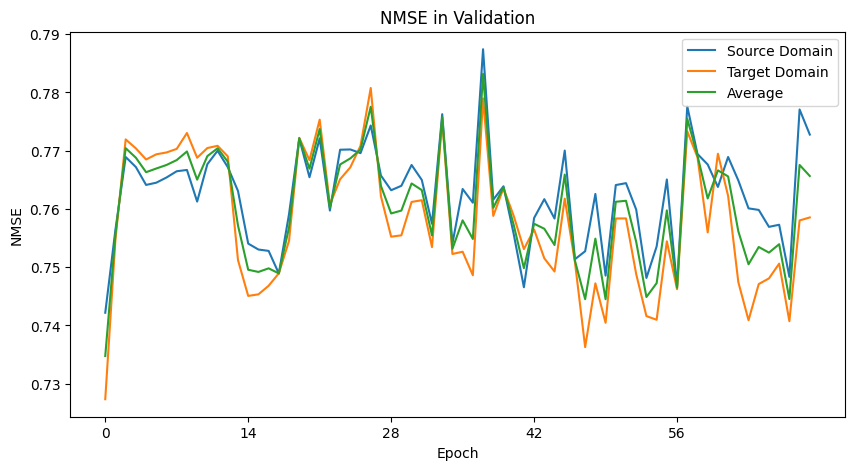

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotfig.figLoss(line_list=[(nmse_val_source, 'Source Domain'), (nmse_val_target, 'Target Domain'), (nmse_val, 'Average')], xlabel='Epoch', ylabel='NMSE',
#                         title='NMSE in Validation', index_save=1, fig_show=True, fig_name='NMSE_val')
            

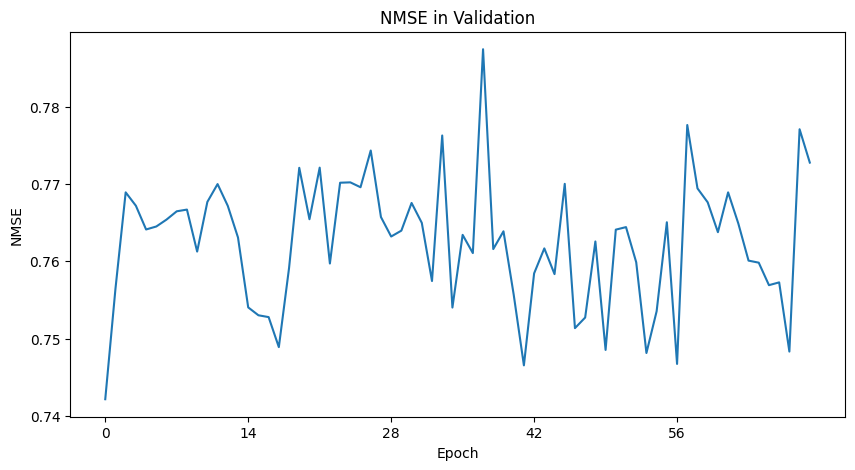

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotfig.figLoss(line_list=[(nmse_val_source, 'Source Domain')], xlabel='Epoch', ylabel='NMSE',
#                         title='NMSE in Validation', index_save=1, fig_show=True, fig_name='NMSE_val')
            